## <span style="color:red">Important: Before running this notebook, make sure the mosfit, corner, matplotlib, and seaborn libraries are installed in your Python environment (install them with conda or pip).</span>

### Load the data from `walkers.json`, the main output file produced by the last MOSFiT run.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from collections import OrderedDict
from mosfit.plotting import bandcolorf, bandrepf
from corner import arviz_corner
import logging
import arviz as az
import pandas as pd

In [3]:

"""Functions for assisting with plotting, inherited from AstroCats."""

from collections import OrderedDict
from random import seed, shuffle

import seaborn as sns
from matplotlib.colors import rgb2hex
from palettable import colorbrewer, cubehelix, wesanderson

__all__ = [
    'bandrepf', 'bandcolorf', 'radiocolorf', 'xraycolorf', 'bandaliasf',
    'bandshortaliasf', 'bandwavef', 'bandmetaf', 'bandcodes',
    'bandwavelengths',
    'bandgroupf'
]

bandreps = {
    'Ks': ['K_s'],
    'UVM2': ['uvm2', 'UVM2', 'UVm2', 'Um2', 'um2'],
    'UVW1': ['uvw1', 'UVW1', 'UVw1', 'Uw1', 'uw1'],
    'UVW2': ['uvw2', 'UVW2', 'UVw2', 'Uw2', 'uw2'],
}

# Some bands are uniquely tied to an instrument/telescope/system, add this
# info here.
bandmeta = {
    'UVM2': {'telescope': 'Swift', 'instrument': 'UVOT'},
    'UVW1': {'telescope': 'Swift', 'instrument': 'UVOT'},
    'UVW2': {'telescope': 'Swift', 'instrument': 'UVOT'},
    'F110W': {'telescope': 'Hubble', 'instrument': 'WFC3'},
    'F775W': {'telescope': 'Hubble', 'instrument': 'WFC3'},
    'F850LP': {'telescope': 'Hubble', 'instrument': 'WFC3'}
}

bandcodes = [
    "u",
    "g",
    "r",
    "i",
    "z",
    "u'",
    "g'",
    "r'",
    "i'",
    "z'",
    "u_SDSS",
    "g_SDSS",
    "r_SDSS",
    "i_SDSS",
    "z_SDSS",
    "U",
    "B",
    "V",
    "R",
    "I",
    "G",
    "Y",
    "J",
    "H",
    "K",
    "C",
    "CR",
    "CV",
    "UVM2",
    "UVW1",
    "UVW2",
    "pg",
    "Mp",
    "w",
    "y",
    "Z",
    "F110W",
    "F775W",
    "F850LP",
    "VM",
    "RM",
    "Ks",
    "orange",
    "cyan"
]

bandaliases = OrderedDict([
    ("u_SDSS", "u'"),
    ("g_SDSS", "g'"),
    ("r_SDSS", "r'"),
    ("i_SDSS", "i'"),
    ("z_SDSS", "z'")
])

bandshortaliases = OrderedDict([
    ("u_SDSS", "u'"),
    ("g_SDSS", "g'"),
    ("r_SDSS", "r'"),
    ("i_SDSS", "i'"),
    ("z_SDSS", "z'"),
    ("G", "")
])

bandwavelengths = {
    "orange": 675.,
    "u": 354.,
    "g": 475.,
    "r": 622.,
    "i": 763.,
    "z": 905.,
    "y": 963.,
    "u'": 354.,
    "g'": 475.,
    "r'": 622.,
    "i'": 763.,
    "z'": 905.,
    "U": 365.,
    "B": 445.,
    "V": 551.,
    "R": 658.,
    "I": 806.,
    "Y": 1020.,
    "J": 1220.,
    "H": 1630.,
    "K": 2190.,
    "UVM2": 260.,
    "UVW1": 224.,
    "UVW2": 193.,
    "cyan": 528.
}

bandgroups = {
    "SDSS": ["u'", "g'", "r'", "i'", "z'"],
    "UVOT": ["UVW2", "UVM2", "UVW1"],
    "HST": ['F110W', 'F775W', 'F850LP'],
    "Johnson": ['U', 'B', 'V', 'R', 'I', 'Y', 'J', 'H', 'K'],
    "HKO": ['orange', 'cyan']
}

radiocodes = [
    "5.9"
]
xraycodes = [
    "0.3 - 10",
    "0.5 - 8"
]

seed(101)
bandcolors = ["#%06x" % round(float(x)/float(len(bandcodes))*0xFFFEFF)
for x in range(len(bandcodes))]
bandcolors = (cubehelix.cubehelix1_16.hex_colors[3:14] +
              cubehelix.cubehelix2_16.hex_colors[3:14] +
              cubehelix.cubehelix3_16.hex_colors[3:14])
shuffle(bandcolors)
bandcolors2 = cubehelix.perceptual_rainbow_16.hex_colors
shuffle(bandcolors2)
bandcolors = bandcolors + bandcolors2
bandcolordict = dict(list(zip(bandcodes, bandcolors)))

radiocolors = wesanderson.Zissou_5.hex_colors
shuffle(radiocolors)
radiocolordict = dict(list(zip(radiocodes, radiocolors)))

xraycolors = colorbrewer.sequential.Oranges_9.hex_colors[2:]
shuffle(xraycolors)
xraycolordict = dict(list(zip(xraycodes, xraycolors)))


def bandrepf(code):
    """Replace code with band name."""
    for rep in bandreps:
        if code in bandreps[rep]:
            return rep
    return code


def bandcolorf(code):
    """Replace band code with color."""
    newcode = bandrepf(code)
    if newcode in bandcolordict:
        return bandcolordict[newcode]
    return newcode


def radiocolorf(freq):
    """Replace radio code with color."""
    ffreq = (float(freq) - 1.0) / (45.0 - 1.0)
    pal = sns.diverging_palette(200, 60, l=80, as_cmap=True, center="dark")
    return rgb2hex(pal(ffreq))


def xraycolorf(code):
    """Replace xray code with color."""
    if code in xraycolordict:
        return xraycolordict[code]
    return 


def bandaliasf(code):
    """Replace band alias with name."""
    newcode = bandrepf(code)
    if newcode in bandaliases:
        return bandaliases[newcode]
    return


def bandgroupf(code):
    """Replace band code with group."""
    newcode = bandrepf(code)
    for group in bandgroups:
        if newcode in bandgroups[group]:
            return group
    return ''


def bandshortaliasf(code):
    """Replace band code with short alias."""
    newcode = bandrepf(code)
    if newcode in bandshortaliases:
        return bandshortaliases[newcode]
    return 


def bandwavef(code):
    """Replace band code with wavelength."""
    newcode = bandrepf(code)
    if newcode in bandwavelengths:
        return bandwavelengths[newcode]
    return 0.


def bandmetaf(band, field):
    """Replace band with meta."""
    if band in bandmeta:
        if field in bandmeta[band]:
            return bandmeta[band][field]
    return ''


In [4]:
sns.reset_orig()

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 14})

with open(r"C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Project\scripts\products\walkers.json", 'r', encoding = 'utf-8') as f:
    data = json.loads(f.read())
    if 'name' not in data:
        data = data[list(data.keys())[0]]

photo = data['photometry']
model = data['models'][0]

real_data = len([x for x in photo if 'band' in x and 'magnitude' in x and (
    'realization' not in x or 'simulated' in x)]) > 0

band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
band_list = list(set([tuple(x.get(y, '')
                            for y in band_attr) for x in photo
                            if 'band' in x and 'magnitude' in x]))
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
xray_instrument_attr = ['instrument', 'telescope']
xray_instrument_list = list(set([tuple(x.get(y, '')
                            for y in xray_instrument_attr) for x in photo
                            if 'instrument' in x and 'countrate' in x])) 
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
real_xray_instrument_list = list(set([tuple(x.get(y, '')
                                 for y in xray_instrument_attr) for x in photo
                                 if 'instrument' in x and 'countrate' in x and (
                                     'realization' not in x or 'simulated' in x)]))

### First, plot the comparisson between the observed magnitudes and that predicted by the model.

Photo:   0%|          | 0/2 [00:00<?, ?it/s]

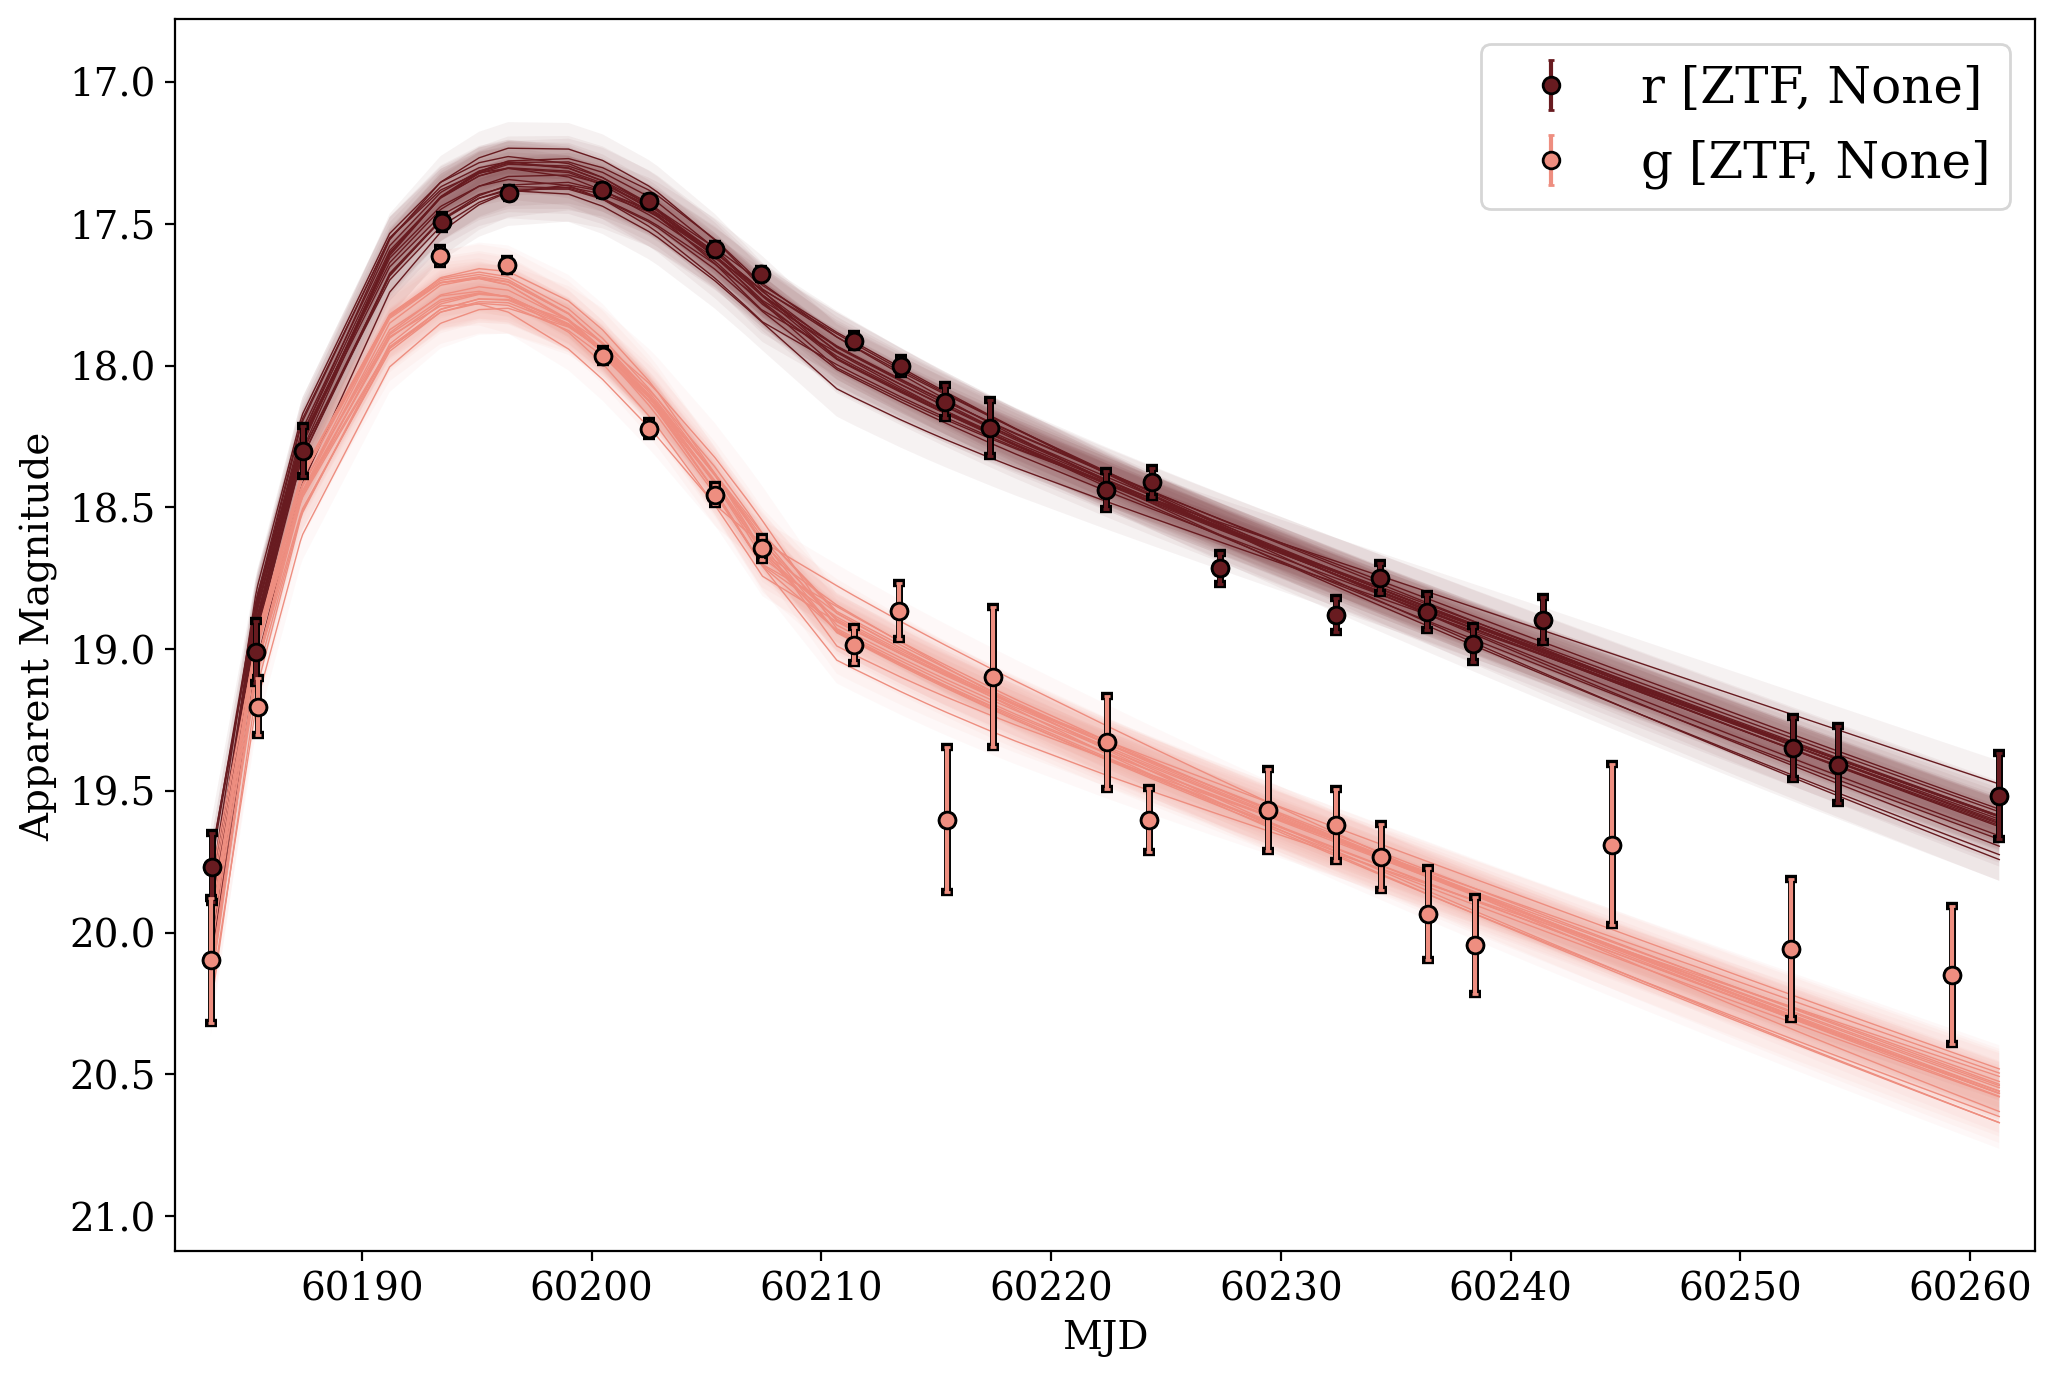

In [16]:
# Uncomment line below to only plot from the specified instruments.
# inst_exclusive_list = ['UVOT']

fig = plt.figure(figsize=(12,8))
plt.gca().invert_yaxis()
plt.gca().set_xlabel('MJD')
plt.gca().set_ylabel('Apparent Magnitude')
used_bands = []
for full_band in tqdm_notebook(band_list, desc='Photo', leave=False):
    (band, inst, tele, syst, bset) = full_band
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst, bset)).keys())))
    nice_name = band + ((' [' + extra_nice + ']') if extra_nice else '')
    
    realizations = [[] for x in range(len(model['realizations']))]
    for ph in photo:
        rn = ph.get('realization', None)
        si = ph.get('simulated', False)
        if rn and not si:
            if tuple(ph.get(y, '') for y in band_attr) == full_band:
                realizations[int(rn) - 1].append((
                    float(ph['time']), float(ph['magnitude']), [
                        float(ph.get('e_lower_magnitude', ph.get('e_magnitude', 0.0))),
                        float(ph.get('e_upper_magnitude', ph.get('e_magnitude', 0.0)))],
                ph.get('upperlimit')))
    numrz = np.sum([1 for x in realizations if len(x)])
    for rz in realizations:
        if not len(rz):
            continue
        xs, ys, vs, us = zip(*rz)
        label = '' if full_band in used_bands or full_band in real_band_list else nice_name
        if max(vs) == 0.0:
            plt.plot(xs, ys, color=bandcolorf(band),
                             label=label, linewidth=0.5)
        else:
            xs = np.array(xs)
            ymi = np.array(ys) - np.array([np.inf if u else v[0] for v, u in zip(vs, us)])
            yma = np.array(ys) + np.array([v[1] for v in vs])
            plt.fill_between(xs, ymi, yma, color=bandcolorf(band), edgecolor=None,
                             label=label, alpha=1.0/numrz, linewidth=0.0)
            plt.plot(xs, ys, color=bandcolorf(band), 
                             label=label, alpha=1.0, linewidth=0.5)
        if label:
            used_bands = list(set(used_bands + [full_band]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time']), float(x['magnitude']),
                    0.0 if 'upperlimit' in x else float(x.get('e_lower_magnitude', x.get('e_magnitude', 0.0))),
                    float(x.get('e_upper_magnitude', x.get('e_magnitude', 0.0)))) for x in photo
                   if 'magnitude' in x and ('realization' not in x or 'simulated' in x) and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in band_attr) == full_band]
            if not len(vec):
                continue
            xs, ys, yls, yus = zip(*vec)
            label = nice_name if full_band not in used_bands else ''
            plt.errorbar(xs, ys, yerr=(yus, yls), color=bandcolorf(band), fmt=symb,
                         label=label,
                         markeredgecolor='black', markeredgewidth=1, capsize=1,
                         elinewidth=1.5, capthick=2, zorder=10)
            plt.errorbar(xs, ys, yerr=(yus, yls), color='k', fmt=symb, capsize=2,
                         elinewidth=2.5, capthick=3, zorder=5)
            if label:
                used_bands = list(set(used_bands + [full_band]))
plt.margins(0.02, 0.1)
plt.legend(prop={'size': 18})
plt.show()
# fig.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Project\results mosfit\fit_2023qzm.pdf', dpi=200, bbox_inches='tight')

### Then, plot observations reported as count rates (e.g. X-ray observations).

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
used_instruments = []
color = {}
for i in xray_instrument_list:
    color[i[0]] =  next(ax._get_lines.prop_cycler)['color'] # using this to match MOSFiT color scheme

for all_instrument_attr in tqdm_notebook(xray_instrument_list, desc='Photo', leave=False):
    (inst, telscp) = all_instrument_attr
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst)).keys())))
    nice_name = telscp + (('[' + extra_nice + ']') if extra_nice else '')
    realizations = [[] for x in range(len(model['realizations']))]
    alias = ['' for x in range(len(model['realizations']))]
    for ph in photo:
        rn = ph.get('realization', None)
        if rn:
            if tuple(ph.get(y, '') for y in xray_instrument_attr) == all_instrument_attr:
                    realizations[int(rn) - 1].append((float(ph['time']),
                                                      float(ph['countrate']),
                                                      float(ph.get('e_lower_countrate', 0.0)),
                                                      float(ph.get('e_upper_countrate', 0.0))))
                    alias[int(rn) - 1] = ph['realization']
    for i,rz in enumerate(realizations):
        if not len(rz):
            continue
        xs, ys, vls, vus = zip(*rz)
        label = ('' if all_instrument_attr in used_instruments or
                 all_instrument_attr in real_xray_instrument_list else nice_name)
        if max(vs) == 0.0:
            plt.plot(xs, ys, color=color[inst],
                             label=label, linewidth=0.5)
        else:
            xs = np.array(xs)
            ymi = np.array(ys) - np.array(vls)
            yma = np.array(ys) + np.array(vus)
            plt.fill_between(xs, ymi, yma, color=color[inst],
                             label=label, alpha=2.0/len(realizations))

        if label:
            used_instruments = list(set(used_instruments + [all_instrument_attr]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time'][0]), float(x['countrate']), float(x.get('e_countrate', 0.0))) for x in photo
                   if 'countrate' in x and 'realization' not in x and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in xray_instrument_attr) == all_instrument_attr]  
            
            if not len(vec):
                continue
            xs, ys, yes = zip(*vec)
            label = nice_name if all_instrument_attr not in used_instruments else ''

            plt.errorbar(xs, ys, yerr=yes, color = color[inst], fmt=symb,
                         label=label,
                         markeredgecolor='black', markeredgewidth=1, capsize=5,
                         elinewidth=2, capthick=2, zorder=10)
            plt.errorbar(xs, ys, yerr=yes, color='k', fmt=symb, capsize=6,
                         elinewidth=3, capthick=3, zorder=5) 
            if label:
                used_instruments = list(set(used_instruments + [all_instrument_attr]))
plt.gca().set_xlabel('MJD')
plt.gca().set_ylabel('countrates')
#plt.xlim(55200, 56000)
plt.yscale('log')
#plt.ylim(1e-320,1e20)
plt.margins(0.1,0.1)
plt.legend(loc = 'best')
plt.show()
fig.savefig('../products/lc_xrays.pdf')

### If MOSFiT was run with the `-c` flag, this cell will plot the parameter values (with ranges normalized to unity) over the full chain.

In [ ]:
with open('../products/chain.json', 'r', encoding = 'utf-8') as f:
    all_chain = np.array(json.load(f))

nparam = len(all_chain[0,0,0,:]);
fig = plt.figure(figsize=(4. * np.ceil(nparam / 4.), 8));
for pi, param in enumerate(range(nparam)):
    my_chain = all_chain[0, :, :, param]
    ax = fig.add_subplot(np.ceil(nparam / 4.), 4, pi + 1);
    ax.plot(my_chain.T);
    ax.plot(np.mean(my_chain, axis=0), color='k');
plt.tight_layout()

### Lastly, this cell produces a corner plot of all the parameters.

In [ ]:
import logging
logging.disable(logging.WARNING)

# Construct walker arrays for corner
corner_input = []
pars = [x for x in model['setup'] if model['setup'][x].get('kind') == 'parameter' and
        'min_value' in model['setup'][x] and 'max_value' in model['setup'][x]]
weights = []
for realization in model['realizations']:
    par_vals = realization['parameters']
    if 'weight' in realization:
        weights.append(float(realization['weight']))
    var_names = ['$' + ('\\log\\, ' if par_vals[x].get('log') else '') +
                 par_vals[x]['latex'] + '$' for x in par_vals if x in pars and 'fraction' in par_vals[x]]
    corner_input.append([np.log10(par_vals[x]['value']) if
                         par_vals[x].get('log') else par_vals[x]['value'] for x in par_vals
                         if x in pars and 'fraction' in par_vals[x]])
weights = weights if len(weights) else None
ranges = [0.999 for x in range(len(corner_input[0]))]
cfig = corner.corner(corner_input, labels=var_names, quantiles=[0.16, 0.5, 0.84],
                     show_titles=True, weights=weights, range=ranges)
cfig.savefig('../products/corner.pdf')

### The above cells are a demonstration of visualizations of MOSFiT outputs and are not intended to show the full scope of possible outputs, the user is encouraged to experiment with their own notebooks for their projects!